# Importing CSSEGI data into communities
[Index](0-index.ipynb)

In this notebook, we assign CSSEGI data to the communities constructed in [1-clustering](1-clustering.ipynb). Data reported in the CSSEGI dataset is assigned to a community based on the latitude and longitude. Data can be accessed [here](https://github.com/CSSEGISandData/COVID-19).

## Imports and global variables

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mco
import matplotlib.gridspec as mgs
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib import animation
plt.rcParams['svg.fonttype'] = 'none'

from IPython.display import HTML
from IPython.display import Image

In [3]:
sys.path.append('../code')
from functions import plot_omega_profile, plot_omega_map

In [4]:
datadir = Path('../data')
if not datadir.is_dir():
    raise ValueError("Data dir doesn'nt exist!")

In [5]:
resdir = Path('../results/')
if not resdir.is_dir():
    raise ValueError('No results directory!')

In [6]:
complevel=7
complib='zlib'

resfile = resdir / 'safegraph_analysis.hdf5'
# resfile = resdir / 'safegraph_analysis_monthly.hdf5'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    print(f"File {resfile.stem} has {len(store.keys())} entries.")

cssefile = resdir / 'cssegi_sanddata_analysis.hdf5'
with pd.HDFStore(cssefile, complevel=complevel, complib=complib) as store:
    print(f"File {cssefile.stem} has {len(store.keys())} entries.")


File safegraph_analysis has 830 entries.
File cssegi_sanddata_analysis has 0 entries.


In [7]:
tfmt = '%Y-%m-%d'
exts = ['.png', '.svg']

## Load clustered CBGs

In [8]:
key = "/clustering/clusters"
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    clusters = store[key]
clusters

,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
0,746,-65.794825,18.277415,"[720531504003, 720531501044, 720531505001, 720...",390728,8705.198547
1,458,-66.083320,18.131576,"[720572702011, 720572703004, 720572705001, 720...",488287,10942.351090
2,873,-66.079340,18.396328,"[720210307001, 720210310113, 720210316223, 720...",1011530,28389.915254
3,8,-66.344566,18.363775,"[720399559001, 720399556001, 720399557001, 720...",425126,9988.154964
4,641,-66.582628,18.044742,"[721130724005, 721130727011, 721130727012, 721...",354598,12057.116223
...,...,...,...,...,...,...
1019,911,-158.026269,21.423245,"[150030078092, 150030078102, 150030099044, 150...",459209,22780.496368
1020,7,-157.813184,21.329035,"[150090318011, 150099900000, 150030047001, 150...",529047,21868.060533
1021,392,-156.517054,20.867763,"[150090311032, 150090304042, 150090309034, 150...",161290,7878.004843


In [9]:
clusters_pos = clusters.loc[:, ['X','Y']].rename(columns={'X': 'longitude', 'Y': 'latitude'})
clusters_pos

,longitude,latitude
index,,
0,-65.794825,18.277415
1,-66.083320,18.131576
2,-66.079340,18.396328
3,-66.344566,18.363775
4,-66.582628,18.044742
...,...,...
1019,-158.026269,21.423245
1020,-157.813184,21.329035
1021,-156.517054,20.867763


## Load data from geometry

In [10]:
geofile = datadir / 'safegraph_open_census_data'  / 'geometry' / 'cbg.geojson'
if not geofile.is_file():
    raise ValueError("Geo file doesn't exist!")

In [11]:
geo = gpd.read_file(geofile).astype({'CensusBlockGroup': 'int64'})
geo.set_index('CensusBlockGroup', inplace=True)
XY = geo.representative_point().apply(lambda X: [X.x, X.y]).tolist()
df_xy = pd.DataFrame(data=np.array(XY), index=geo.index, columns=['longitude','latitude'])
df_xy

,longitude,latitude
CensusBlockGroup,,
10810416001,-85.359042,32.649834
10810416002,-85.375454,32.649834
10810417004,-85.352368,32.585058
10730111074,-86.623536,33.598117
10730111084,-86.629025,33.605849
...,...,...
720851902012,-65.865443,18.186016
720851902013,-65.863139,18.172725
720851902021,-65.868816,18.176952


## Load the confirmed cases from CSSEGI data

In [12]:
dfile = datadir / 'time_series_covid19_confirmed_US.csv'
df_confirmed_us = pd.read_csv(dfile)
df_confirmed_us = df_confirmed_us.loc[df_confirmed_us['iso2'] == 'US'] # only keep the US
#.astype({'FIPS': 'int64'})
df_confirmed_us

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,6723,6727,6734,6740,6748,6750,6760,6763,6763,6773
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,20631,20638,20652,20670,20674,20701,20714,20723,20730,20764
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2247,2249,2252,2257,2262,2264,2271,2271,2271,2275
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2562,2564,2564,2559,2560,2560,2563,2563,2567,2569
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6483,6488,6497,6507,6511,6519,6529,6532,6532,6548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,3660,3665,3675,3684,3689,3694,3694,3694,3703,3707
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,2142,2145,2153,2153,2155,2155,2155,2155,2150,2155
3339,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,897,897,898,898,898,898,898,898,898,898


Drop the locations with no latitude or longitude information

In [13]:
idx = ( (df_confirmed_us['Lat'] == 0.) | (df_confirmed_us['Long_'] == 0.) )
df_confirmed_us.drop(index=df_confirmed_us.index[idx], inplace=True)
df_confirmed_us

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21
0,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,6723,6727,6734,6740,6748,6750,6760,6763,6763,6773
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,20631,20638,20652,20670,20674,20701,20714,20723,20730,20764
2,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,2247,2249,2252,2257,2262,2264,2271,2271,2271,2275
3,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,2562,2564,2564,2559,2560,2560,2563,2563,2567,2569
4,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,6483,6488,6497,6507,6511,6519,6529,6532,6532,6548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,84056037,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,-108.882788,...,4085,4104,4107,4115,4119,4119,4119,4119,4126,4135
3337,84056039,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,-110.589080,...,3660,3665,3675,3684,3689,3694,3694,3694,3703,3707
3338,84056041,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,-110.547578,...,2142,2145,2153,2153,2155,2155,2155,2155,2150,2155
3340,84056043,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,-107.680187,...,897,897,898,898,898,898,898,898,898,898


## Mapping clusters to CSSEGI FIPS based on (Longitude, Latitude)

In [14]:
clusters_pos.sort_index(inplace=True)
XY_clusters = clusters_pos.loc[:, ['longitude', 'latitude']].to_numpy()

In [15]:
XY_csse = df_confirmed_us.loc[:, ['Long_', 'Lat']].to_numpy()

In [16]:
# iterate over CSSEGI data
cluster_ids = []
for i in range(len(df_confirmed_us.index)):
    xy = XY_csse[i]
    imin = np.argmin(np.linalg.norm(XY_clusters - xy, axis=1))
    cluster_ids.append(clusters_pos.index[imin])

In [17]:
col = 'cluster_id'
if col in df_confirmed_us.columns:
    del df_confirmed_us[col]

df_confirmed_us.insert(1, col, cluster_ids)
df_confirmed_us

,UID,cluster_id,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,...,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21
0,84001001,202,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,...,6723,6727,6734,6740,6748,6750,6760,6763,6763,6773
1,84001003,168,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,...,20631,20638,20652,20670,20674,20701,20714,20723,20730,20764
2,84001005,184,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,...,2247,2249,2252,2257,2262,2264,2271,2271,2271,2275
3,84001007,188,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,...,2562,2564,2564,2559,2560,2560,2563,2563,2567,2569
4,84001009,193,US,USA,840,1009.0,Blount,Alabama,US,33.982109,...,6483,6488,6497,6507,6511,6519,6529,6532,6532,6548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3336,84056037,847,US,USA,840,56037.0,Sweetwater,Wyoming,US,41.659439,...,4085,4104,4107,4115,4119,4119,4119,4119,4126,4135
3337,84056039,835,US,USA,840,56039.0,Teton,Wyoming,US,43.935225,...,3660,3665,3675,3684,3689,3694,3694,3694,3703,3707
3338,84056041,845,US,USA,840,56041.0,Uinta,Wyoming,US,41.287818,...,2142,2145,2153,2153,2155,2155,2155,2155,2150,2155
3340,84056043,817,US,USA,840,56043.0,Washakie,Wyoming,US,43.904516,...,897,897,898,898,898,898,898,898,898,898


### Retain only the dates and cluster_ID

In [18]:
dates = []
for c in df_confirmed_us.columns:
    try:
        t = datetime.datetime.strptime(c, '%m/%d/%y')
        dates.append(c)
    except ValueError:
        continue

In [19]:
columns = ['cluster_id'] + dates

df_clusters = df_confirmed_us.loc[:, columns].groupby('cluster_id').apply(sum)
del df_clusters['cluster_id']
df_clusters

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,4/11/21,4/12/21,4/13/21,4/14/21,4/15/21,4/16/21,4/17/21,4/18/21,4/19/21,4/20/21
cluster_id,,,,,,,,,,,,,,,,,,,,,
8,0,0,0,0,0,0,0,0,0,0,...,1473,1496,1511,1522,1531,1544,1556,1560,1561,1567
9,0,0,0,0,0,0,0,0,0,0,...,398,398,401,405,407,412,416,420,423,424
10,0,0,0,0,0,0,0,0,0,0,...,795,795,797,799,805,807,807,808,809,816
11,0,0,0,0,0,0,0,0,0,0,...,1131,1149,1161,1169,1177,1185,1193,1194,1201,1202
12,0,0,0,0,0,0,0,0,0,0,...,4859,4886,4921,4955,4998,5015,5048,5068,5076,5116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,0,0,0,0,0,0,0,0,0,0,...,657,658,679,679,679,681,681,681,683,686
1018,0,0,0,0,0,0,0,0,0,0,...,202,202,202,202,202,202,203,203,203,203
1019,0,0,0,0,0,0,0,0,0,0,...,24243,24291,24330,24365,24422,24537,24585,24678,24730,24754


In [20]:
clusters_csse = pd.DataFrame(data=np.zeros((len(clusters.index),len(df_clusters.columns)), np.uint), index=clusters.index, columns=df_clusters.columns)
clusters_csse.loc[df_clusters.index] = df_clusters
clusters_csse = clusters_csse.T
clusters_csse.index = [datetime.datetime.strptime(s, '%m/%d/%y') for s in clusters_csse.index]
clusters_csse

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16,0,0,0,0,0,0,0,0,1544,412,...,0,0,681,0,202,24537,0,4100,2671,0
2021-04-17,0,0,0,0,0,0,0,0,1556,416,...,0,0,681,0,203,24585,0,4136,2682,0
2021-04-18,0,0,0,0,0,0,0,0,1560,420,...,0,0,681,0,203,24678,0,4142,2692,0
2021-04-19,0,0,0,0,0,0,0,0,1561,423,...,0,0,683,0,203,24730,0,4152,2694,0


I currently have one empty community.

In [21]:
clusters.loc[1017].to_frame().T

,leaves,X,Y,cbg_clusters,population,mobile_count
1017,236,-175.828603,27.854941,[150039812001],0,0.0


But the reported number of cases there is zero.

In [22]:
clusters_csse.loc[clusters_csse.index[-1], 1017]

0

There is one community where the reported number of cases is larger than the population...

In [23]:
idx = (clusters_csse.loc[clusters_csse.index[-1]] > clusters['population']).to_numpy()
np.sum(idx)

1

In [24]:
clusters.loc[clusters.index[idx]]

,leaves,X,Y,cbg_clusters,population,mobile_count
index,,,,,,
962,335,-116.314411,34.189739,"[60710114041, 60710104202, 60710103002, 607101...",73301,3731.605327


In [25]:
clusters_csse.loc[clusters_csse.index[-1], clusters.index[idx]].to_frame().T

index,962
2021-04-20,294973


So I correct this:

In [26]:
for t in clusters_csse.index:
    x = np.min(np.array([clusters_csse.loc[t].to_numpy(), clusters['population'].to_numpy()], dtype=np.int_), axis=0)
    clusters_csse.loc[t] = x

clusters_csse

index,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
2020-01-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-16,0,0,0,0,0,0,0,0,1544,412,...,0,0,681,0,202,24537,0,4100,2671,0
2021-04-17,0,0,0,0,0,0,0,0,1556,416,...,0,0,681,0,203,24585,0,4136,2682,0
2021-04-18,0,0,0,0,0,0,0,0,1560,420,...,0,0,681,0,203,24678,0,4142,2692,0
2021-04-19,0,0,0,0,0,0,0,0,1561,423,...,0,0,683,0,203,24730,0,4152,2694,0


In [27]:
idx = (clusters_csse.loc[clusters_csse.index[-1]] > clusters['population']).to_numpy()
np.sum(idx)

0

In [28]:
total_csse = clusters_csse.sum(axis=1).to_frame()
total_csse.rename(columns={0: 'omega'}, inplace=True)
total_csse

,omega
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2021-04-16,31049278
2021-04-17,31100231
2021-04-18,31140463
2021-04-19,31205359


### Write

In [29]:
key = '/clustering/cssegi'
with pd.HDFStore(resfile, complevel=complevel, complib=complib) as store:
    store[str(key)] = clusters_csse

## Plots

In [30]:
figdir = Path('../figures') / '3-import_cssegi'
if not figdir.is_dir():
    figdir.mkdir(parents=True, exist_ok=True)

### Plot the total evolution

In [31]:
# parameters
figsize = (6,4.5)
dpi = 300
ms=2
lw=1


fig = plt.figure(facecolor='w', figsize=figsize)
ax = fig.gca()

ax.plot(total_csse.index.to_numpy(), total_csse.sum(axis=1).to_numpy(), '-', ms=ms, color='darkblue')

ax.set_yscale('log')
ax.set_xlim(total_csse.index[0],None)
ax.set_ylabel("$T$", fontsize="medium")
plt.xticks(rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True)
ax.tick_params(axis='both', length=4)
fig.tight_layout()

fname = 'omega_tot_cssegi'
for ext in exts:
    filepath = figdir / (fname + ext)
    fig.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=dpi)
    print("Written file: {:s}".format(str(filepath)))
fig.clf()
plt.close('all')

Written file: ../figures/3-import_cssegi/omega_tot_cssegi.png
Written file: ../figures/3-import_cssegi/omega_tot_cssegi.svg


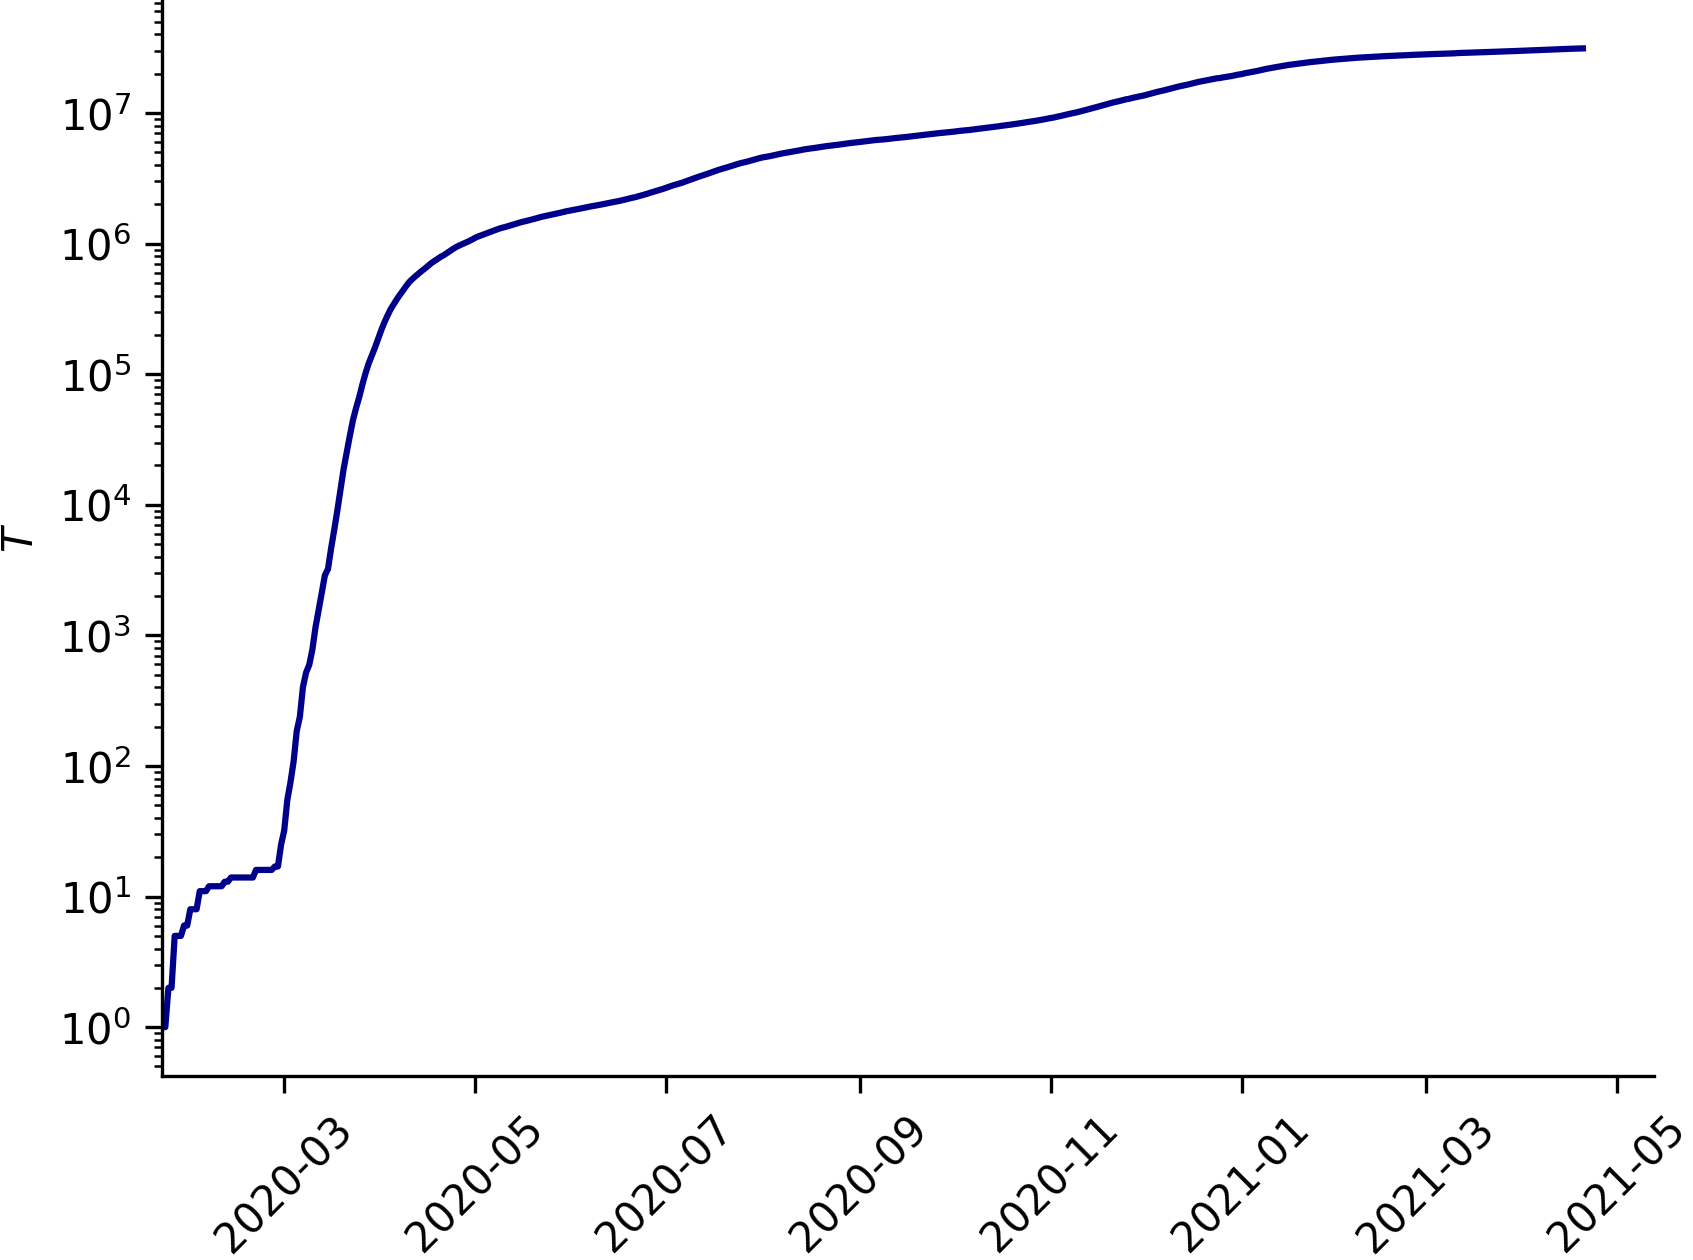

In [32]:
filepath = figdir / (fname + '.png')
Image(filename=filepath, width=4./3*360)

### Plot the spatial evolution as a profile

In [33]:
clusters_csse.iloc[-1].max()/1.0e6

1.229641

In [34]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4
ylabel="$T_a$"

fileout = figdir / 'dynamic_profile.mp4'
mydir = figdir / 'profiles'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)

In [35]:
plot_omega_profile(np.array([clusters_csse.to_numpy()]), clusters_csse.index.to_list(), colors=['red'], \
                   fileout=fileout, tpdir=mydir, dpi=dpi, fps=fps, figsize=figsize, ylabel=ylabel, \
                   lw=lw, ms=ms, styles=['o'], deletetp=False, exts=['.png','.svg'], ymin=1., ymax=1.3e6)

ymin = 1.00e+00 ymax = 1.30e+06
Written file ../figures/3-import_cssegi/profiles/2020-01-22.png.
Written file ../figures/3-import_cssegi/profiles/2020-02-01.png.
Written file ../figures/3-import_cssegi/profiles/2020-02-11.png.
Written file ../figures/3-import_cssegi/profiles/2020-02-21.png.
Written file ../figures/3-import_cssegi/profiles/2020-03-02.png.
Written file ../figures/3-import_cssegi/profiles/2020-03-12.png.
Written file ../figures/3-import_cssegi/profiles/2020-03-22.png.
Written file ../figures/3-import_cssegi/profiles/2020-04-01.png.
Written file ../figures/3-import_cssegi/profiles/2020-04-11.png.
Written file ../figures/3-import_cssegi/profiles/2020-04-21.png.
Written file ../figures/3-import_cssegi/profiles/2020-05-01.png.
Written file ../figures/3-import_cssegi/profiles/2020-05-11.png.
Written file ../figures/3-import_cssegi/profiles/2020-05-21.png.
Written file ../figures/3-import_cssegi/profiles/2020-05-31.png.
Written file ../figures/3-import_cssegi/profiles/2020-06-1

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (795, 605) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/3-import_cssegi/dynamic_profile.mp4.


In [36]:
HTML("""
<video height="480" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fileout)))

### Plot the spatial evolution on a map

In [37]:
clusters_csse.iloc[-1].max()/1.0e6

1.229641

In [38]:
fileout = figdir / 'dynamic_profile.mp4'
mydir = figdir / 'maps'
if not mydir.is_dir():
    mydir.mkdir(parents=True, exist_ok=True)
fileout = figdir / 'dynamic_map.mp4'

In [39]:
# parameters
dpi=150
fps=10
figsize=(6, 4.5)
lw=0.5
ms=4
idump=1


fileout = figdir / 'map_T.mp4'
plot_omega_map(clusters_csse.to_numpy(), clusters_csse.index.to_list(), XY=clusters.loc[:, ['X', 'Y']].to_numpy().T, \
fileout=fileout, tpdir=mydir, dpi=dpi, fps=fps, figsize=figsize, idump=idump, \
               clabel="$T$", vmin=1., vmax=1.3e6, deletetp=False, exts=['.png','.svg'])

vmin = 1.00e+00 vmax = 1.30e+06
Written file ../figures/3-import_cssegi/maps/2020-01-22.png.
Written file ../figures/3-import_cssegi/maps/2020-01-23.png.
Written file ../figures/3-import_cssegi/maps/2020-01-24.png.
Written file ../figures/3-import_cssegi/maps/2020-01-25.png.
Written file ../figures/3-import_cssegi/maps/2020-01-26.png.
Written file ../figures/3-import_cssegi/maps/2020-01-27.png.
Written file ../figures/3-import_cssegi/maps/2020-01-28.png.
Written file ../figures/3-import_cssegi/maps/2020-01-29.png.
Written file ../figures/3-import_cssegi/maps/2020-01-30.png.
Written file ../figures/3-import_cssegi/maps/2020-01-31.png.
Written file ../figures/3-import_cssegi/maps/2020-02-01.png.
Written file ../figures/3-import_cssegi/maps/2020-02-02.png.
Written file ../figures/3-import_cssegi/maps/2020-02-03.png.
Written file ../figures/3-import_cssegi/maps/2020-02-04.png.
Written file ../figures/3-import_cssegi/maps/2020-02-05.png.
Written file ../figures/3-import_cssegi/maps/2020-02-

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (867, 488) to (880, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Written file ../figures/3-import_cssegi/maps/map_T.mp4.


In [40]:
HTML("""
<video height="480" controls>
  <source src="{:s}" type="video/mp4">
</video>
""".format(str(fileout)))